# Predictions_Analysis

Hate speech, however, continues to be an important challenge, and multimodal hate speech remains an especially difficult machine learning problem. Hate speech is defined as a direct attack (characterized as violent or dehumanizing speech, harmful stereotypes, statements of inferiority, expressions of contempt, disgust or dismissal, cursing, and calls for exclusion or segregation) against people on the basis of what we call protected characteristics (characterized as race, ethnicity, national origin, disability, religious affiliation, caste, sexual orientation, sex, gender identity and serious disease). We operationalize this definition by making fine-grained labels for protected classes and attack types available as additional annotations on the hateful memes dataset.
Task A (multi-label): For each meme, detect the protected category. Protected categories are: race, disability, religion, nationality, sex. If the meme is not_hateful the protected category is: pc_empty.
Task B (multi-label): For each meme, detect the attack type. Attack types are: contempt, mocking, inferiority, slurs, exclusion, dehumanizing, inciting_violence. If the meme is not_hateful the protected category is: attack_empty.

In [2]:
import os
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn.metrics import confusion_matrix
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_lg")

In [2]:
# helpers
def auc_score(org_file, ens_file):
    fpr, tpr, thresholds = metrics.roc_curve(org_file['label'], ens_file['proba'],  pos_label=1)
    return round(metrics.auc(fpr, tpr), 3)

In [3]:
# import dev predictions and dev with annotations of type hateful
dev_seen_results = pd.read_csv("ensembled_dev_seen_SA.csv")

# fairface features
fairface = pd.read_json("annotations_fairface.json")

dev_seen = pd.read_json("dev_seen.jsonl", lines = True)
dev_seen_htype = pd.read_json("dev_seen_htype.json", lines = True)
dev_seen_htype['label'] = dev_seen['label']
dev_seen_htype['match_predict'] = dev_seen_results['label'] == dev_seen['label']

## Overall metrics

In [6]:
auc_score(dev_seen, dev_seen_results)

0.808

In [7]:
accuracy_score(dev_seen['label'], dev_seen_results['label'])

0.734

## Metrics by hateful type

- **Protected Category** -> `gold_pc`: *race, disability, religion, nationality, sex*. If the meme is not_hateful the protected category is: *pc_empty*.

- **Attack Type** -> `gold_attack`: *contempt, mocking, inferiority, slurs, exclusion, dehumanizing, inciting_violence*. If the meme is not_hateful the protected category is: *attack_empty*.

In [4]:
ch = []
for gp in dev_seen_htype['gold_attack']:
    if gp == ['attack_empty']:
        ch.append('attack_empty')
    elif gp == ['contempt']:
        ch.append('contempt')
    elif gp == ['mocking']:
        ch.append('mocking')
    elif gp == ['inferiority']:
        ch.append('inferiority')
    elif gp == ['slurs']:
        ch.append('slurs')
    elif gp == ['exclusion']:
        ch.append('exclusion')
    elif gp == ['dehumanizing']:
        ch.append('dehumanizing')
    elif gp == ['inciting_violence']:
        ch.append('inciting_violence')
    else:
        ch.append('multiple')
        
dev_seen_htype['gold_attack2'] = ch

In [5]:
gp_ = []
for gp in dev_seen_htype['gold_pc']:
    if gp == ['pc_empty']:
        gp_.append('pc_empty')
    elif gp == ['race']:
        gp_.append('race')
    elif gp == ['disability']:
        gp_.append('disability')
    elif gp == ['religion']:
        gp_.append('religion')
    elif gp == ['nationality']:
        gp_.append('nationality')
    elif gp == ['sex']:
        gp_.append('sex')
    else:
        gp_.append('multiple')
        
dev_seen_htype['gold_pc'] = gp_

In [6]:
df_dev_join=pd.merge(dev_seen_htype, fairface[['id', 'face_race']],  how='left', on='id', indicator=True)

In [7]:
# race, disability, religion, nationality, sex and pc_empty.
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'pc_empty' if(x == ['pc_empty']) else x)
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'race' if(x == ['race']) else x)
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'disability' if(x == ['disability']) else x)
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'religion' if(x == ['religion']) else x)
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'nationality' if(x == ['nationality']) else x)
dev_seen_htype['gold_pc'] = dev_seen_htype['gold_pc'].map(lambda x: 'sex' if(x == ['sex']) else x)

In [8]:
dev_seen_htype.groupby('gold_attack2')['label'].count()

gold_attack2
attack_empty         257
contempt               8
dehumanizing         108
exclusion              9
inciting_violence     19
inferiority           44
mocking               33
multiple              17
slurs                  5
Name: label, dtype: int64

In [9]:
dev_seen_htype.groupby('gold_attack2')['gold_pc'].count()

gold_attack2
attack_empty         257
contempt               8
dehumanizing         108
exclusion              9
inciting_violence     19
inferiority           44
mocking               33
multiple              17
slurs                  5
Name: gold_pc, dtype: int64

In [14]:
bplot=dev_seen_htype.groupby('gold_attack2').agg({'label': 'count'})

In [15]:
dev_seen_htype.groupby('label')['gold_attack2'].count()

label
0    253
1    247
Name: gold_attack2, dtype: int64

## Bar Plot `gold_attack`

<AxesSubplot:xlabel='label', ylabel='gold_attack2'>

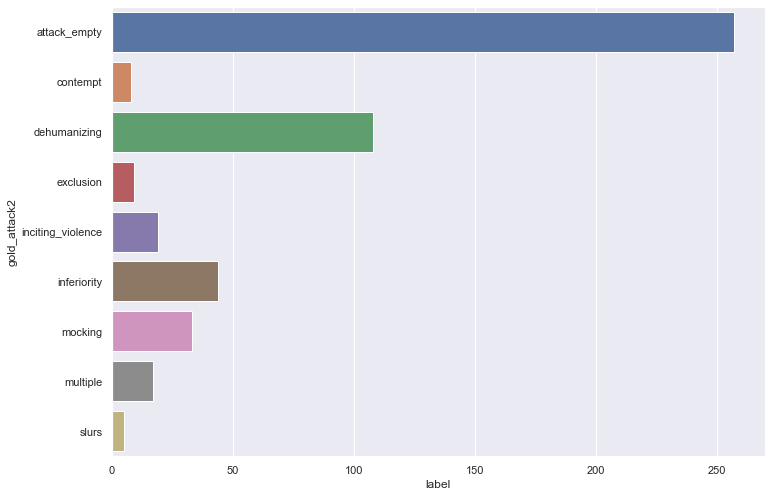

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="label", y=bplot.index, orient = "h", data=bplot)

## Bar Plot `gold_pc`

In [21]:
bbplot_gold_pc = dev_seen_htype.groupby('gold_pc').agg({'label': 'count'})

<AxesSubplot:xlabel='gold_pc', ylabel='label'>

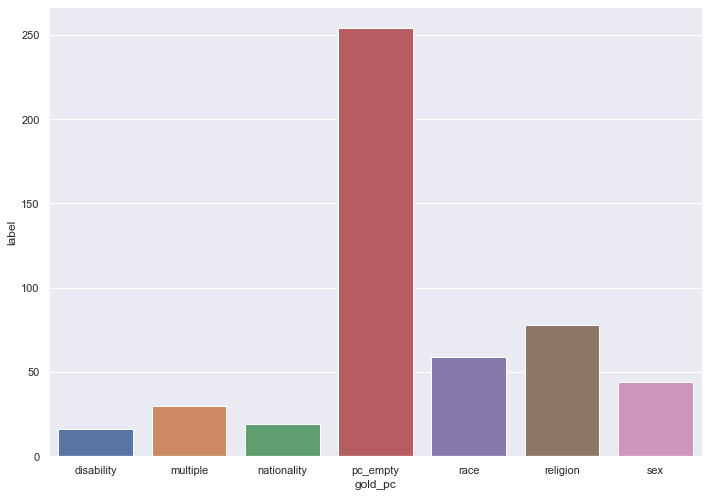

In [22]:
sns.barplot(x=bbplot_gold_pc.index, y="label", data=bbplot_gold_pc)

## Predictions match

In [23]:
confusion_matrix(dev_seen['label'], dev_seen_results['label'])

array([[179,  74],
       [ 59, 188]])

In [74]:
bplot_results = pd.concat([dev_seen_htype.groupby('gold_pc').agg({'label': 'count'}),
     dev_seen_htype.groupby('gold_pc').agg({'match_predict': 'sum'})], axis = 1)
# add percentage Col in _ df
bplot_results_ = bplot_results.copy()
bplot_results_['perc'] = bplot_results['match_predict']/bplot_results['label']*100
bplot_results_

,label,match_predict,perc
gold_pc,,,
disability,16,13,81.250000
multiple,30,19,63.333333
nationality,19,15,78.947368
pc_empty,254,177,69.685039
race,59,46,77.966102
religion,78,62,79.487179
sex,44,35,79.545455


In [61]:
# we melt the df in order to use more than one col in barplot
melt_bplot_results = pd.melt(bplot_results)
melt_bplot_results['gold_pc'] = ('disability', 'multiple', 'nationality', 'pc_empty', 'race',
       'religion', 'sex',
                                 'disability', 'multiple', 'nationality', 'pc_empty', 'race',
       'religion', 'sex')

In [200]:
melt_bplot_results

,variable,value,gold_pc
0,label,16,disability
1,label,30,multiple
2,label,19,nationality
3,label,254,pc_empty
4,label,59,race
5,label,78,religion
6,label,44,sex
7,match_predict,13,disability
8,match_predict,19,multiple
9,match_predict,15,nationality


In [64]:
plot_order =['pc_empty', 'religion', 
             'race', 
             'sex',
             'multiple',
             'nationality',
             'disability']

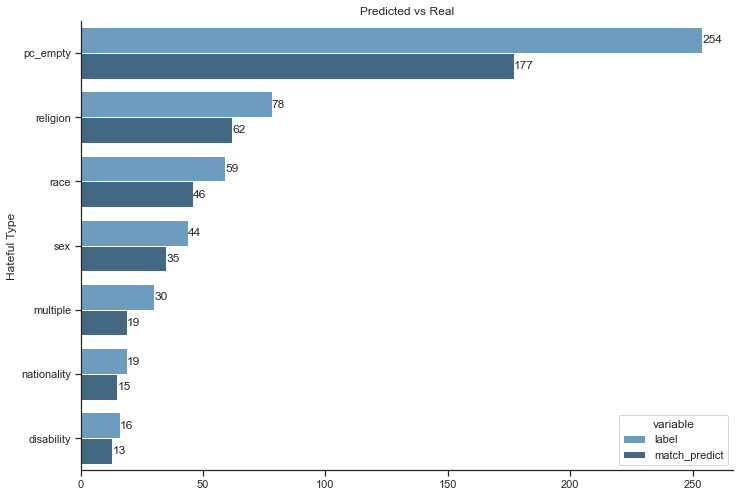

In [218]:
ax=sns.barplot(x='value', y='gold_pc', orient = "h", hue='variable', 
            order=plot_order, palette="Blues_d", data=melt_bplot_results)
ax.set_title("Predicted vs Real")
ax.set_xlabel("")
ax.set_ylabel("Hateful Type")

for container in ax.containers:
    ax.bar_label(container)

## Where is wrong in race, nationality

In [189]:
wrong_race_pred=df_dev_join[df_dev_join.gold_pc.isin(["race"]) &
                  ~df_dev_join.match_predict.isin([True])]

In [197]:
len(wrong_race_pred['id'].unique())

13

In [199]:
wrong_race_pred[['id','text','face_race']]

,id,text,face_race
309,83745,it is time.. to send these parasites back to t...,NaN
316,82301,cooooooooooooon!!!!,NaN
322,53968,when you have an 80 point iq but it's the high...,NaN
397,17682,give them what they deserve kill them all,NaN
401,29873,who knew that this country is full of white trash,NaN
416,43810,how to cook turkey in usa how to cook turkey i...,NaN
456,98701,oh no i can't steal anymore,NaN
506,73601,when you are white and stole your first bike,NaN
530,26943,my incesters built this country!!!!,[White]
558,56241,94% of them test positive for rh blood type wh...,"[White, White, White, Indian, White, White, Wh..."


# Most used words

In [228]:
meme_anno_path = "annotations"

# read the original files
meme_anno_test_unseen = {}
anno_file_test_unseen = os.path.join(meme_anno_path, 'test_unseen.jsonl')
with open(anno_file_test_unseen, 'r') as f:
    for l in f:
        data = json.loads(l)
        meme_anno_test_unseen[data['id']] = data

meme_anno_test = {}
anno_file_test = os.path.join(meme_anno_path, 'test_seen.jsonl')
with open(anno_file_test, 'r') as f:
    for l in f:
        data = json.loads(l)
        meme_anno_test[data['id']] = data

meme_anno_dev = {}
anno_file_dev = os.path.join(meme_anno_path, 'dev_seen.jsonl')
with open(anno_file_dev, 'r') as f:
    for l in f:
        data = json.loads(l)
        meme_anno_dev[data['id']] = data

# join org annotations files

meme_anno = {**meme_anno_test_unseen, **meme_anno_test, **meme_anno_dev}

In [245]:
anno_text=[]
for i, (id, anno) in enumerate(meme_anno.items()):
    anno_text.append((anno['text']))

In [249]:
keyword_tok=list(nlp(' '.join(anno_text)))

In [254]:
doc = (keyword_tok)
# all tokens that arent stop words or punctuations
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct]

# noun tokens that arent stop words or punctuations
nouns = [token.text
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(25)

# five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(25)

In [255]:
print("word_freq",common_words)
print("common_nouns",common_nouns)

word_freq [('like', 180), ('people', 138), ('white', 109), ('black', 109), ('day', 82), ('gas', 80), ('know', 78), ('dishwasher', 77), ('look', 76), ('time', 76), ('love', 72), ('man', 71), ('want', 69), ('new', 68), ('got', 56), ('girl', 53), ('face', 52), ('way', 52), ('life', 52), ('world', 51), ('islam', 50), ('good', 49), ('muslim', 49), ('hate', 49), ('jewish', 46)]
common_nouns [('people', 138), ('day', 82), ('dishwasher', 77), ('time', 76), ('gas', 69), ('man', 66), ('girl', 53), ('life', 52), ('world', 48), ('face', 41), ('way', 41), ('women', 41), ('today', 40), ('difference', 39), ('muslims', 37), ('dad', 36), ('race', 34), ('country', 33), ('thing', 31), ('kid', 31), ('men', 30), ('children', 30), ('school', 29), ('wife', 28), ('shit', 27)]


# Most freq words 2.

In [3]:
# import data annotation with hateful type
dev_seen=pd.read_json("annotations_with_tag_type/dev_seen.json", lines = True)
test_seen=pd.read_json("annotations_with_tag_type/dev_unseen.json", lines = True)
train=pd.read_json("annotations_with_tag_type/train.json", lines = True)

to_concat = [dev_seen, test_seen, train]
hateful_memes = pd.concat(to_concat)

In [5]:
def clean_type(df):
    # clean gold_attack
    ch = []
    for gp in df['gold_attack']:
        if gp == ['attack_empty']:
            ch.append('attack_empty')
        elif gp == ['contempt']:
            ch.append('contempt')
        elif gp == ['mocking']:
            ch.append('mocking')
        elif gp == ['inferiority']:
            ch.append('inferiority')
        elif gp == ['slurs']:
            ch.append('slurs')
        elif gp == ['exclusion']:
            ch.append('exclusion')
        elif gp == ['dehumanizing']:
            ch.append('dehumanizing')
        elif gp == ['inciting_violence']:
            ch.append('inciting_violence')
        elif gp == ['None']:
            ch.append('None')
        else:
            ch.append('multiple')

    df['gold_attack'] = ch
    
    # clean gold_pc
    gp_ = []
    for gp in df['gold_pc']:
        if gp == ['pc_empty']:
            gp_.append('pc_empty')
        elif gp == ['race']:
            gp_.append('race')
        elif gp == ['disability']:
            gp_.append('disability')
        elif gp == ['religion']:
            gp_.append('religion')
        elif gp == ['nationality']:
            gp_.append('nationality')
        elif gp == ['sex']:
            gp_.append('sex')
        else:
            gp_.append('multiple')

    df['gold_pc'] = gp_
    return df

In [6]:
hateful_memes=clean_type(hateful_memes)

In [180]:
# most freq word function --- HELPER
def frequent_word(data):
    doc = nlp(data)
    words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    freq_word = Counter(words)
    return(freq_word)


# function for `frequent_word`, filtering and join data text
def freq_word_filter(data, header, label, n_show = 20):
    """
    input: -> data: hm dataset.
    header: Col name that we want filter.
    label: label name that we want filter.
    output: -> most n frequent words in pd dataframe 
    and the % that represent respect total words.
    -------------------------------------------------------------
    def: function filter the data by the `header` and `label`, then
    join all text df and return the `n_show` most frequent words 
    and the % that represent respect total words.
    """
    # filter the data
    data = data[data[header] == label]
    print("There are {} hateful gold_pc:".format(data.shape), label)
    data = data['text'].apply(lambda x:x + ' ').sum()
    freq_wrods = frequent_word(data)
    freq_wrods = pd.DataFrame.from_dict(freq_wrods, orient='index').reset_index()
    freq_wrods = freq_wrods.rename(columns={'index': 'Word', 0: 'Frequency'})
    freq_wrods['freq_perc'] = freq_wrods['Frequency'].map(lambda x: round((x/freq_wrods['Frequency'].sum())*100, 2))
    freq_wrods = freq_wrods.sort_values(by = 'Frequency', ascending=False).reset_index()
    return freq_wrods[:n_show]

## Most freq Words in protected category `gold_pc`
race, disability, religion, nationality, sex. If the meme is not_hateful the protected category is: pc_empty.

### Most freq Words - `race`

In [248]:
freq_word_filter(hateful_memes, 'gold_pc', 'race').to_csv("race_freq_words.csv")

There are (909, 9) hateful gold_pc: race


In [181]:
freq_word_filter(hateful_memes, 'gold_pc', 'race')

There are (909, 9) hateful gold_pc: race


,index,Word,Frequency,freq_perc
0,122,black,232,4.25
1,0,white,204,3.74
2,1,people,158,2.89
3,76,like,88,1.61
4,84,trash,45,0.82
5,75,racist,39,0.71
6,492,got,26,0.48
7,451,nigger,25,0.46
8,389,know,24,0.44
9,53,day,22,0.40


### Most freq Words - `disability`

In [249]:
freq_word_filter(hateful_memes, 'gold_pc', 'disability').to_csv("disability_freq_words.csv")

There are (213, 9) hateful gold_pc: disability


In [182]:
freq_word_filter(hateful_memes, 'gold_pc', 'disability')

There are (213, 9) hateful gold_pc: disability


,index,Word,Frequency,freq_perc
0,122,retarded,18,1.64
1,113,got,11,1.00
2,59,kid,9,0.82
3,43,vegetable,8,0.73
4,198,know,7,0.64
5,112,autistic,7,0.64
6,69,slow,7,0.64
7,224,special,7,0.64
8,151,m,6,0.55
9,78,pussy,6,0.55


### Most freq Words - `religion`

In [250]:
freq_word_filter(hateful_memes, 'gold_pc', 'religion').to_csv("religion_freq_words.csv")

There are (1028, 9) hateful gold_pc: religion


In [183]:
freq_word_filter(hateful_memes, 'gold_pc', 'religion')

There are (1028, 9) hateful gold_pc: religion


,index,Word,Frequency,freq_perc
0,63,muslim,156,2.34
1,54,muslims,144,2.16
2,143,jews,91,1.37
3,53,islam,76,1.14
4,60,people,70,1.05
5,384,kill,64,0.96
6,154,goat,58,0.87
7,68,allah,48,0.72
8,6,fuck,46,0.69
9,48,gas,41,0.62


### Most freq Words - `nationality`

In [251]:
freq_word_filter(hateful_memes, 'gold_pc', 'nationality').to_csv("nationality_freq_words.csv")

There are (225, 9) hateful gold_pc: nationality


In [184]:
freq_word_filter(hateful_memes, 'gold_pc', 'nationality')

There are (225, 9) hateful gold_pc: nationality


,index,Word,Frequency,freq_perc
0,7,mexicans,20,1.43
1,41,illegal,19,1.36
2,50,like,19,1.36
3,65,africa,11,0.79
4,21,people,11,0.79
5,59,refugees,10,0.72
6,218,polish,9,0.64
7,107,americans,9,0.64
8,1,know,9,0.64
9,42,aliens,9,0.64


### Most freq Words - `sex`

In [252]:
freq_word_filter(hateful_memes, 'gold_pc', 'sex').to_csv("sex_freq_words.csv")

There are (633, 9) hateful gold_pc: sex


In [185]:
freq_word_filter(hateful_memes, 'gold_pc', 'sex')

There are (633, 9) hateful gold_pc: sex


,index,Word,Frequency,freq_perc
0,6,tranny,82,2.08
1,83,women,68,1.73
2,24,dishwasher,61,1.55
3,16,like,60,1.52
4,39,gay,53,1.35
5,44,men,41,1.04
6,130,man,33,0.84
7,276,woman,27,0.69
8,95,people,27,0.69
9,376,transgender,24,0.61


### Most freq Words - `multiple`

In [253]:
freq_word_filter(hateful_memes, 'gold_pc', 'multiple').to_csv("multiple_freq_words.csv")

There are (442, 9) hateful gold_pc: multiple


In [186]:
freq_word_filter(hateful_memes, 'gold_pc', 'multiple')

There are (442, 9) hateful gold_pc: multiple


,index,Word,Frequency,freq_perc
0,47,white,51,1.54
1,16,black,48,1.45
2,98,like,36,1.09
3,17,people,35,1.06
4,280,women,34,1.03
5,43,girl,32,0.97
6,113,muslim,29,0.88
7,116,men,25,0.76
8,63,country,25,0.76
9,115,gay,23,0.70


### Most freq Words - `pc_empty`

In [216]:
freq_word_filter(hateful_memes, 'gold_pc', 'pc_empty').to_csv("pc_empty_freq_word.csv")

There are (6090, 9) hateful gold_pc: pc_empty


In [254]:
freq_word_filter(hateful_memes, 'gold_pc', 'pc_empty')

There are (6090, 9) hateful gold_pc: pc_empty


,index,Word,Frequency,freq_perc
0,22,like,408,1.28
1,46,people,310,0.97
2,16,time,166,0.52
3,1,day,156,0.49
4,162,got,150,0.47
5,122,look,146,0.46
6,80,white,146,0.46
7,11,want,132,0.41
8,108,man,129,0.40
9,83,fuck,128,0.40


In [9]:
perc_hm = pd.concat([hateful_memes.groupby('gold_pc').agg({'id': 'count'})], axis = 1)
perc_hm = perc_hm.rename(columns={'id': 'count'})
perc_hm['perc'] = round((perc_hm['count']/perc_hm['count'].sum())*100, 2)
perc_hm = perc_hm.sort_values(by = 'count', ascending = False).reset_index()

In [8]:
perc_hm_=perc_hm[perc_hm['gold_pc'] != 'pc_empty']

Text(0, 0.5, 'Protected Categories-gold_pc')

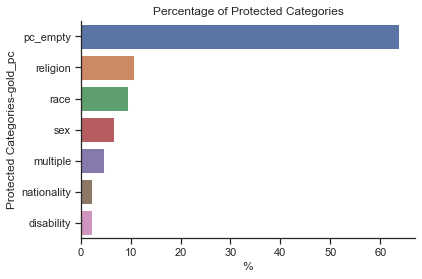

In [11]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="perc", y='gold_pc', 
                  orient = "h", 
                  data=perc_hm)
ax.set_title("Percentage of Protected Categories")
ax.set_xlabel("%")
ax.set_ylabel("Protected Categories-gold_pc")


#for container in ax.containers:
#    ax.bar_label(container)

In [12]:
perc_hm

,gold_pc,count,perc
0,pc_empty,6090,63.84
1,religion,1028,10.78
2,race,909,9.53
3,sex,633,6.64
4,multiple,442,4.63
5,nationality,225,2.36
6,disability,213,2.23
